Install mpi4py

In [3]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185305 sha256=44abd00c3066b34c09956bef8e81ef421d0ea17a58be4546e18e0b5bd1daeb9e
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


# MPI Introduction

Official website:
* https://www.mpi-forum.org/
* https://mpi4py.readthedocs.io/en/stable/

The **Message Passing Interface (MPI)** is a standardized and portable message-passing system designed to function on a wide variety of parallel computers. The MPI standard defines the syntax and semantics of library routines and allows users to write portable programs in the main scientific programming languages (Fortran, C, or C++). Since its release, the MPI specification has become the leading standard for message-passing libraries for parallel computers.

**mpi4py** provides a Python interface to MPI or the Message-Passing Interface. It is useful for parallelizing Python scripts.

# MPI Example: Communicators and Ranks

In [4]:
%%writefile hello.py
from mpi4py import MPI

if __name__ == "__main__":
  # instantize the communication world 
  world_comm = MPI.COMM_WORLD
  # get the size of the communication world 
  world_size = world_comm.Get_size()
  # get this particular processes' `rank` ID
  my_rank = world_comm.Get_rank()
  print("World Size: " + str(world_size) + "   " + "Rank: " + str(my_rank))

Writing hello.py


In [5]:
!ls

hello.py  mpiScatter1.py  sample_data


In [6]:
!cat hello.py

from mpi4py import MPI

if __name__ == "__main__":
  # instantize the communication world 
  world_comm = MPI.COMM_WORLD
  # get the size of the communication world 
  world_size = world_comm.Get_size()
  # get this particular processes' `rank` ID
  my_rank = world_comm.Get_rank()
  print("World Size: " + str(world_size) + "   " + "Rank: " + str(my_rank))

We can run it on 4 different processes, specified by `-n 4` in the following command:

In [ ]:
!mpiexec --allow-run-as-root -n 4 python hello.py

World Size: 4   Rank: 2
World Size: 4   Rank: 3
World Size: 4   Rank: 1
World Size: 4   Rank: 0


In [ ]:
!mpiexec --allow-run-as-root -n 10 python hello.py

World Size: 10   Rank: 3
World Size: 10   Rank: 9
World Size: 10   Rank: 1
World Size: 10   Rank: 2
World Size: 10   Rank: 4
World Size: 10   Rank: 5
World Size: 10   Rank: 6
World Size: 10   Rank: 0
World Size: 10   Rank: 7
World Size: 10   Rank: 8


# Point to Point Communicators

Point to point communication is a fundamental capability of message passing systems. This mechanism enables the transmission of data between a pair of processes, one side sending, the other receiving.

MPI provides a set of send and receive functions allowing the communication of typed data with an associated tag. The type information enables the conversion of data representation from one architecture to another in the case of heterogeneous computing environments; additionally, it allows the representation of non-contiguous data layouts and user-defined datatypes, thus avoiding the overhead of (otherwise unavoidable) packing/unpacking operations. The tag information allows selectivity of messages at the receiving end.

## Basic Example

In [ ]:
%%file mpiSendRecv1.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD   # create a communicator
rank = comm.Get_rank()  # Get the rank of the current process
size = comm.Get_size()

# master process
if rank == 0:
  # master process sends data to worker processes by
  # going through the ranks of all worker processes
  for i in range(1, size):
    data = np.arange(4.) + i*10
    comm.Send(data, dest=i, tag=i)
    print('Process {} sent data:'.format(rank), data)

# worker processes
else:
  # initialize the receiving buffer
  data = np.zeros(4)
  # receive data from master process
  comm.Recv(data, source=0, tag=rank)
  print('Process {} received data:'.format(rank), data)

Writing mpiSendRecv1.py


In [ ]:
!mpirun --allow-run-as-root -n 5 python mpiSendRecv1.py

Process 0 sent data: [10. 11. 12. 13.]
Process 0 sent data: [20. 21. 22. 23.]
Process 1 received data: [10. 11. 12. 13.]
Process 3 received data: [30. 31. 32. 33.]
Process 2 received data: [20. 21. 22. 23.]
Process 0 sent data: [30. 31. 32. 33.]
Process 0 sent data: [40. 41. 42. 43.]
Process 4 received data: [40. 41. 42. 43.]


## Send and receive a numpy array:

In [ ]:
%%file mpiSendRecv2.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    # in real code, this section might
    # read in data parameters from a file
    numData = 10  
    comm.send(numData, dest=1)

    data = np.linspace(0.0,3.14,numData)  
    comm.Send(data, dest=1) # automatic MPI datatype discovery

elif rank == 1:

    numData = comm.recv(source=0)
    print('Number of data to receive: ',numData)

    data = np.empty(numData, dtype='d')  # allocate space to receive the array
    comm.Recv(data, source=0) # automatic MPI datatype discovery

    print('data received: ',data)

Writing mpiSendRecv2.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python mpiSendRecv2.py

Number of data to receive:  10
data received:  [0.         0.34888889 0.69777778 1.04666667 1.39555556 1.74444444
 2.09333333 2.44222222 2.79111111 3.14      ]


Communication of generic Python objects: You have to use methods with **all-lowercase names**, like `Comm.send`, `Comm.recv`, `Comm.bcast`, `Comm.scatter`, `Comm.gather`. An object to be sent is passed as a parameter to the communication call, and the received object is simply the return value.

The `Comm.recv` method may be passed a buffer object that can be repeatedly used to receive messages avoiding internal memory allocation. This buffer must be sufficiently large to accommodate the transmitted messages; hence, any buffer passed to `Comm.recv` must be at least as long as the pickled data transmitted to the receiver.

## Send and receive a Python object

In [ ]:
%%file mpi_sendrecv.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1)
elif rank == 1:
    data = comm.recv(source=0)
    print(data)

Writing mpi_sendrecv.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python mpi_sendrecv.py

{'a': 7, 'b': 3.14}


## Non-blocking send and receive

Python objects with non-blocking communication. The `Comm.isend` and `Comm.irecv` methods return `Request` instances; completion of these methods can be managed using the `Request.test` and `Request.wait` methods.

In [ ]:
%%file mpi_sendrecv2.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    req = comm.isend(data, dest=1, tag=11)
    req.wait()
elif rank == 1:
    req = comm.irecv(source=0, tag=11)
    data = req.wait()
    print(data)

Writing mpi_sendrecv2.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python mpi_sendrecv2.py

{'a': 7, 'b': 3.14}


## Tag

When we tag the send() and recv(), we can guarantee the order of receiving of messages, thus we can be sure that one message will be delivered before another

During dynamic transfer of data, situations arise where, we need a particular send() to match a particular recv() to achieve a kind of synchronization. This can be done using the "tag" parameter in both send() and recv().

For example a send() can look like : comm.send(shared_data,dest=2,tag=1) and a matching recv() to the above statement would look like: comm.recv(source=1,tag=1)

So, this structure forces a match, leading to synchronization of data transfers. The advantage of tagging is that a recv() can be made to wait till it receives data from a corresponding send() with the expected tag. But, this has to be used with extreme care as it can lead to a deadlock state.

In [ ]:
%%file mpiSendRecv_Tagged.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank==0:
	shared_data1 = 23
	comm.send(shared_data1, dest=3, tag=1)
	shared_data2 = 34
	comm.send(shared_data2, dest=3, tag=2)
 
if rank==3:
	recv_data1 = comm.recv(source=0, tag=2)
	print(recv_data1)
	recv_data2 = comm.recv(source=0, tag=1)
	print(recv_data2)

Writing mpiSendRecv_Tagged.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiSendRecv_Tagged.py

34
23


## Combined Send and Receive

MPI_Sendrecv is a combination of an MPI_Send and an MPI_Recv. It can be seen as having both subroutines executed concurrently. 

In [ ]:
%%file mpiSendRecv_Exchange.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

data = np.arange(10, dtype=float) * (rank*10 + 1) # send buffer
buffer = np.zeros(10, float)                   # receive buffer

print("Before: Rank %d: %s, %s" % (rank, str(data), str(buffer)))

if rank == 0:
    comm.Sendrecv(data, dest=1, recvbuf=buffer, source=1)
elif rank == 1:
    comm.Sendrecv(data, dest=0, recvbuf=buffer, source=0)

print("After: Rank %d: %s" % (rank, str(buffer)))

Writing mpiSendRecv_Exchange.py


In [ ]:
!mpirun --allow-run-as-root -n 2 python mpiSendRecv_Exchange.py

Before: Rank 1: [ 0. 11. 22. 33. 44. 55. 66. 77. 88. 99.], [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Before: Rank 0: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
After: Rank 0: [ 0. 11. 22. 33. 44. 55. 66. 77. 88. 99.]
After: Rank 1: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


# Collective Communication

Collective communications allow the transmittal of data between multiple processes of a group simultaneously. The syntax and semantics of collective functions is consistent with point-to-point communication. Collective functions communicate typed data, but messages are not paired with an associated tag; selectivity of messages is implied in the calling order. Additionally, collective functions come in blocking versions only.

In MPI for Python, the `Comm.Bcast`, `Comm.Scatter`, `Comm.Gather`, `Comm.Allgather`, `Comm.Alltoall` methods provide support for collective communications of memory buffers. The lower-case variants `Comm.bcast`, `Comm.scatter`, `Comm.gather`, `Comm.allgather` and `Comm.alltoall` can communicate general Python objects. The vector variants (which can communicate different amounts of data to each process) `Comm.Scatterv`, `Comm.Gatherv`, `Comm.Allgatherv`, `Comm.Alltoallv` and `Comm.Alltoallw` are also supported, they can only communicate objects exposing memory buffers.


Global reducion operations on memory buffers are accessible through the `Comm.Reduce`, `Comm.Reduce_scatter`, `Comm.Allreduce`, `Intracomm.Scan` and `Intracomm.Exscan` methods. The lower-case variants `Comm.reduce`, `Comm.allreduce`, `Intracomm.scan` and `Intracomm.exscan` can communicate general Python objects; however, the actual required reduction computations are performed sequentially at some process. All the predefined (i.e., `SUM`, `PROD`, `MAX`, etc.) reduction operations can be applied.


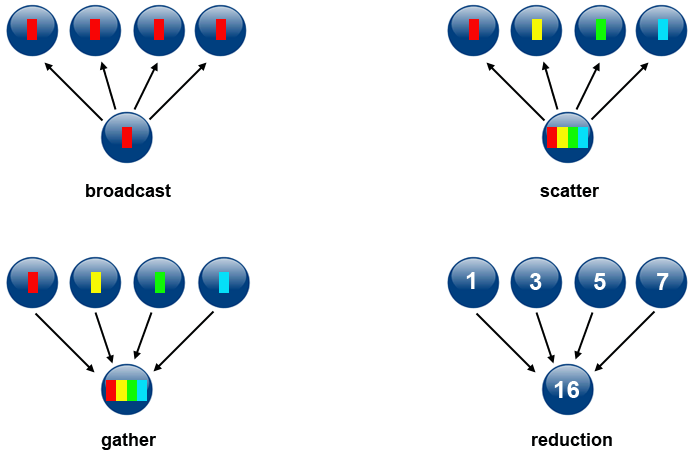

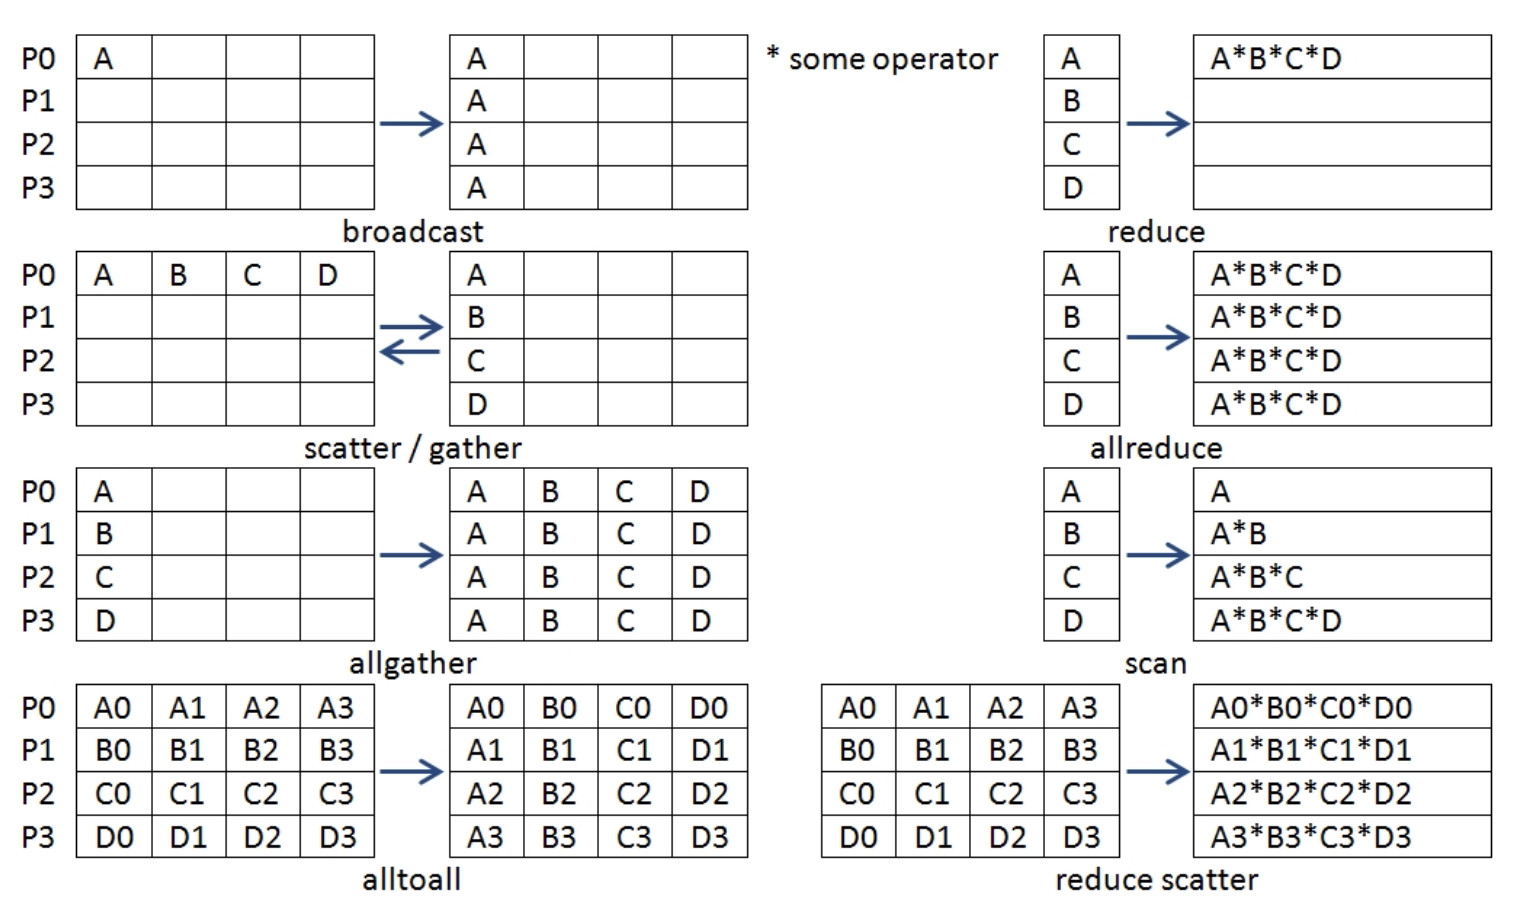

## Broadcast

Broadcasting takes a variable and sends an exact copy of it to all processes on a communicator.

* `comm.bcast` for broadcasting python objects
* `comm.Bcast` for broadcasting raw data
* Pay attension to their usage difference:
> * `data = comm.bcast(data, root=0)`
> * `comm.Bcast(data, root=0)`

In [ ]:
%%file mpiBroadcast1.py

from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Create some data in the RANK_0 worker
if rank == 0:
    py_data = {'key1' : [7, 2.72, 2+3j], 'key2' : ( 'abc', 'xyz')}
else:
    py_data = None

# Broadcast the data from RANK_0 to all workers
# The second parameter "root=0" indicates from where we are getting the data from.
py_data = comm.bcast(py_data, root=0)

# Append the RANK ID to the data
py_data['key1'].append(rank)

# Print the resulting data
print(f"Rank: {rank}, py_data: {data}")

Writing mpiBroadcast1.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiBroadcast1.py

Traceback (most recent call last):
  File "mpiBroadcast1.py", line 23, in <module>
    print(f"Rank: {rank}, py_data: {data}")
NameError: name 'data' is not defined
Traceback (most recent call last):
  File "mpiBroadcast1.py", line 23, in <module>
    print(f"Rank: {rank}, py_data: {data}")
NameError: name 'data' is not defined
Traceback (most recent call last):
  File "mpiBroadcast1.py", line 23, in <module>
    print(f"Rank: {rank}, py_data: {data}")
NameError: name 'data' is not defined
Traceback (most recent call last):
  File "mpiBroadcast1.py", line 23, in <module>
    print(f"Rank: {rank}, py_data: {data}")
NameError: name 'data' is not defined
-------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code.. Per user-direction, the job has been aborted.
-------------------------------------------------------
--------------------------------------------------------------------------
mpirun detected that one or

In [ ]:
%%file mpiBroadcast2.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    # create a data array on process 0
    # in real code, this section might
    # read in data parameters from a file
    numData = 10  
    data = np.linspace(0.0,3.14,numData)  
else:
    numData = None

# broadcast numData and allocate array on other ranks:
numData = comm.bcast(numData, root=0)
if rank != 0:    
    data = np.empty(numData, dtype='d')  

comm.Bcast(data, root=0) # broadcast the array from rank 0 to all others

print('Rank: ', rank, ', data received: ', data)

Writing mpiBroadcast2.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiBroadcast2.py

Rank:  0 , data received:  [0.         0.34888889 0.69777778 1.04666667 1.39555556 1.74444444
 2.09333333 2.44222222 2.79111111 3.14      ]
Rank:  1 , data received:  [0.         0.34888889 0.69777778 1.04666667 1.39555556 1.74444444
 2.09333333 2.44222222 2.79111111 3.14      ]
Rank:  2 , data received:  [0.         0.34888889 0.69777778 1.04666667 1.39555556 1.74444444
 2.09333333 2.44222222 2.79111111 3.14      ]
Rank:  3 , data received:  [0.         0.34888889 0.69777778 1.04666667 1.39555556 1.74444444
 2.09333333 2.44222222 2.79111111 3.14      ]


## Scatter

Scatter takes an array and distributes contiguous sections of it across the ranks of a communicator.

Scatter a numpy array vs Scatter python objects
* `comm.Scatter(data, recvbuf, root=0) `
* `new_data = comm.scatter(py_data, root=0)`

Scatter a numpy array on 4 processes

In [17]:
%%file mpiScatter1.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size() # new: gives number of ranks in comm
rank = comm.Get_rank()

numDataPerRank = 10  
data = None
if rank == 0:
    data = np.linspace(1, size*numDataPerRank, numDataPerRank*size)
    # when size=4 (using -n 4), data = [1.0:40.0]

recvbuf = np.empty(numDataPerRank, dtype='d') # allocate space for recvbuf
comm.Scatter(data, recvbuf, root=0)

print('Rank: ', rank, ', recvbuf received: ', recvbuf)

Overwriting mpiScatter1.py


In [18]:
!mpirun --allow-run-as-root -n 4 python mpiScatter1.py

Traceback (most recent call last):
  File "mpiScatter1.py", line 15, in <module>
    comm.Scatter(data, recvbuf, root=0)
  File "mpi4py/MPI/Comm.pyx", line 740, in mpi4py.MPI.Comm.Scatter
  File "mpi4py/MPI/msgbuffer.pxi", line 597, in mpi4py.MPI._p_msg_cco.for_scatter
  File "mpi4py/MPI/msgbuffer.pxi", line 495, in mpi4py.MPI._p_msg_cco.for_cco_send
  File "mpi4py/MPI/msgbuffer.pxi", line 252, in mpi4py.MPI.message_simple
ValueError: message: cannot infer count, number of entries 10 is not a multiple of required number of blocks 4
[warn] Epoll ADD(4) on fd 41 failed.  Old events were 0; read change was 0 (none); write change was 1 (add): Bad file descriptor


Scatter a Python list

In [ ]:
%%file mpiScatter2.py
from mpi4py import MPI
import numpy as np
from sys import stdout

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

assert size == 4

if rank == 0:
    # Python sequence, lenght has to be equal number to MPI tasks
    py_data = ['foo', 'bar', 11.2, {'key' : 22}]
else:
    py_data = None

new_data = comm.scatter(py_data, root=0)

print("rank ", rank, ': ', new_data)

stdout.flush()
comm.Barrier()

Writing mpiScatter2.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiScatter2.py

rank  0 :  foo
rank  2 :  11.2
rank  3 :  {'key': 22}
rank  1 :  bar


## Gather

The reverse of a scatter is a gather, which takes subsets of an array that are distributed across the ranks, and gathers them back into the full array. 

Pay attension to the difference between gatterring np arrays and gattering Python objects
* `comm.Gather(sendbuf, recvbuf, root=0)`
* `new_data = comm.gather(py_data, root=1)`

Gatter a numpy array

In [ ]:
%%file mpiGather1.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()   

numDataPerRank = 10  
sendbuf = np.linspace(rank*numDataPerRank+1,(rank+1)*numDataPerRank,numDataPerRank)
print('Rank: ', rank, ', sendbuf: ', sendbuf)

recvbuf = None
if rank == 0:
    recvbuf = np.empty(numDataPerRank*size, dtype='d')  

comm.Gather(sendbuf, recvbuf, root=0)

if rank == 0:
    print('Rank: ', rank, ', recvbuf received: ', recvbuf)

Writing mpiGather1.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiGather1.py

Rank:  2 , sendbuf:  [21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
Rank:  3 , sendbuf:  [31. 32. 33. 34. 35. 36. 37. 38. 39. 40.]
Rank:  0 , sendbuf:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Rank:  1 , sendbuf:  [11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
Rank:  0 , recvbuf received:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40.]


Gatter python objects

In [ ]:
%%file mpiGather2.py
from mpi4py import MPI
import numpy as np
from sys import stdout

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

assert size == 4

# Let's create different Python objects for different MPI tasks
if rank == 0:
    py_data = 'foo.bar'
elif rank == 1:
    py_data = 12.34
elif rank == 2:
    py_data = {'key1' : 99.0, 'key2' : [-1, 2.3]}
else:
    py_data = [6.5, 4.3]

new_data = comm.gather(py_data, root=1)

print("rank ", rank, new_data)

stdout.flush()
comm.Barrier()

Writing mpiGather2.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiGather2.py

rank  3 None
rank  0 None
rank  2 None
rank  1 ['foo.bar', 12.34, {'key1': 99.0, 'key2': [-1, 2.3]}, [6.5, 4.3]]


In [ ]:
%%file mpiAllGather.py
from mpi4py import MPI
import numpy as np
from sys import stdout

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

data = (rank + 1) **2

recvdata = comm.allgather(data)

print("rank {} received {} after gather".format(rank, recvdata))


Writing mpiAllGather.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiAllGather.py

rank 0 received [1, 4, 9, 16] after gather
rank 2 received [1, 4, 9, 16] after gather
rank 1 received [1, 4, 9, 16] after gather
rank 3 received [1, 4, 9, 16] after gather


## Reduce

The MPI reduce operation takes values in from an array on each process and reduces them to a single result on the root process. A few commonly used operations are:
* MPI_SUM - Sums the elements.
* MPI_PROD - Multiplies all elements.
* MPI_MAX - Returns the maximum element.
* MPI_MIN - Returns the minimum element.


Reduce np array data

In [9]:
%%file mpiReduction.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# Create some np arrays on each process:
# For this demo, the arrays have only one
# entry that is assigned to be the rank of the processor
value = np.array(rank,'d')

print(' Rank: ', rank, ' value = ', value)

# initialize the np arrays that will store the results:
value_sum = np.array(0.0, 'd')
value_max = np.array(0.0, 'd')

# perform the reductions:
comm.Reduce(value, value_sum, op=MPI.SUM, root=0)
comm.Reduce(value, value_max, op=MPI.MAX, root=0)

if rank == 0:
    print(' Rank 0: value_sum =    ',value_sum)
    print(' Rank 0: value_max =    ',value_max)

Writing mpiReduction.py


In [10]:
!mpirun --allow-run-as-root -n 4 python mpiReduction.py

 Rank:  0  value =  0.0
 Rank:  1  value =  1.0
 Rank:  2  value =  2.0
 Rank:  3  value =  3.0
 Rank 0: value_sum =     6.0
 Rank 0: value_max =     3.0


In [ ]:
%%file mpiallReduce.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

data = (rank + 1) **2

recvdata = comm.allreduce(data, op=MPI.SUM)

print("rank {} received {} elements after reduce".format(rank, recvdata))

Writing mpiallReduce.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiallReduce.py

rank 0 received 30 elements after reduce
rank 1 received 30 elements after reduce
rank 2 received 30 elements after reduce
rank 3 received 30 elements after reduce


In [ ]:
%%file mpiAllReduce.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

senddata = (rank+1)*np.arange(size, dtype=int)
recvdata = np.empty(size, dtype=int)
comm.Allreduce(senddata, recvdata, MPI.SUM)

print("process {} received {} after reduce".format(rank, recvdata))

Writing mpiAllReduce.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiAllReduce.py

process 2 received [ 0 10 20 30] after reduce
process 3 received [ 0 10 20 30] after reduce
process 0 received [ 0 10 20 30] after reduce
process 1 received [ 0 10 20 30] after reduce


## Scan

Computes the scan (partial reductions) of data on a collection of processes

mpi-scan.svg

In [ ]:
%%file mpiScan.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

data = (rank+1)**2
recvdata = comm.scan(data, op=MPI.SUM)

print("rank {} received {} after reduce".format(rank, recvdata))

Writing mpiScan.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python mpiScan.py

rank 0 received 1 after reduce
rank 1 received 5 after reduce
rank 2 received 14 after reduce
rank 3 received 30 after reduce


# All to All

MPI_Alltoall is a collective operation in which all processes send the same amount of data to each other, and receive the same amount of data from each other. The operation of this routine can be represented as follows, where each process performs 2n (n being the number of processes in communicator comm) independent point-to-point communications (including communication with itself).

Each process breaks up its local sendbuf into n blocks - each containing sendcount elements of type sendtype - and divides its recvbuf similarly according to recvcount and recvtype. Process j sends the k-th block of its local sendbuf to process k, which places the data in the j-th block of its local recvbuf. The amount of data sent must be equal to the amount of data received, pairwise, between every pair of processes.



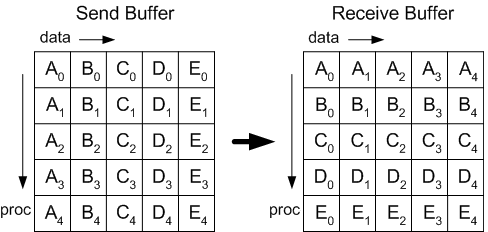

In [ ]:
%%file all2all.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

senddata = (rank+1)*np.arange(size, dtype=int)
recvdata = np.empty(size, dtype=int)
comm.Alltoall(senddata, recvdata)

print(" process %s sending %s receiving %s"\
      %(rank , senddata , recvdata))

Writing all2all.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python all2all.py

 process 0 sending [0 1 2 3] receiving [0 0 0 0]
 process 2 sending [0 3 6 9] receiving [2 4 6 8]
 process 1 sending [0 2 4 6] receiving [1 2 3 4]
 process 3 sending [ 0  4  8 12] receiving [ 3  6  9 12]


# Virtual Topology 

In terms of MPI, a virtual topology describes a mapping/ordering of MPI processes into a geometric “shape”.

The two main types of topologies supported by MPI are Cartesian (grid) and Graph.

MPI topologies are virtual - there may be no relation between the physical structure of the parallel machine and the process topology.

Virtual topologies are built upon MPI communicators and groups.

They must be “programmed” by the application developer.

Virtual topologies may be useful for applications with specific communication patterns - patterns that match an MPI topology structure. For example, a Cartesian topology might prove convenient for an application that requires 4-way nearest neighbor communications for grid based data.

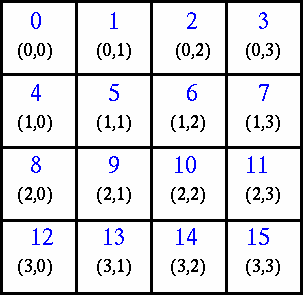

In [ ]:
%%file topology.py
from mpi4py import MPI
import numpy as np

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
neighbour_processes = [0,0,0,0]

if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.rank
    size = comm.size

    grid_row = int(np.floor(np.sqrt(comm.size)))
    grid_column = comm.size // grid_row

        
    if grid_row*grid_column > size:
        grid_column -= 1
    if grid_row*grid_column > size:
        grid_row -= 1

    if (rank == 0) :
        print("Building a %d x %d grid topology:"\
              % (grid_row, grid_column) )
               

    cartesian_communicator = \
                           comm.Create_cart( \
                               (grid_row, grid_column), \
                               periods=(True, True), reorder=True)
    my_mpi_row, my_mpi_col = \
                cartesian_communicator.Get_coords\
                ( cartesian_communicator.rank ) 


    neighbour_processes[UP], neighbour_processes[DOWN]\
                             = cartesian_communicator.Shift(0, 1)
    neighbour_processes[LEFT], neighbour_processes[RIGHT]  = \
                               cartesian_communicator.Shift(1, 1)
    print ("Process = %s row = %s column = %s \n\
--------------------------> \n\
neighbour_processes[UP] = %s\n\
neighbour_processes[DOWN] = %s\n\
neighbour_processes[LEFT] =%s\n\
neighbour_processes[RIGHT]=%s\n" \
            %(rank, my_mpi_row, \
             my_mpi_col,neighbour_processes[UP], \
             neighbour_processes[DOWN], \
             neighbour_processes[LEFT] , \
             neighbour_processes[RIGHT]))

Writing topology.py


In [ ]:
!mpirun --allow-run-as-root -n 16 python topology.py

Building a 4 x 4 grid topology:
Process = 0 row = 0 column = 0 
--------------------------> 
neighbour_processes[UP] = 12
neighbour_processes[DOWN] = 4
neighbour_processes[LEFT] =3
neighbour_processes[RIGHT]=1

Process = 2 row = 0 column = 2 
--------------------------> 
neighbour_processes[UP] = 14
neighbour_processes[DOWN] = 6
neighbour_processes[LEFT] =1
neighbour_processes[RIGHT]=3

Process = 8 row = 2 column = 0 
--------------------------> 
neighbour_processes[UP] = 4
neighbour_processes[DOWN] = 12
neighbour_processes[LEFT] =11
neighbour_processes[RIGHT]=9

Process = 6 row = 1 column = 2 
--------------------------> 
neighbour_processes[UP] = 2
neighbour_processes[DOWN] = 10
neighbour_processes[LEFT] =5
neighbour_processes[RIGHT]=7

Process = 1 row = 0 column = 1 
--------------------------> 
neighbour_processes[UP] = 13
neighbour_processes[DOWN] = 5
neighbour_processes[LEFT] =0
neighbour_processes[RIGHT]=2

Process = 4 row = 1 column = 0 
--------------------------> 
neighbour_p

In [ ]:
%%file mpiSendRecv_Exchange2.py
from mpi4py import MPI
from numpy import zeros, ones

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

data = ones((4,4), float) * -1
data[1:-1,1:-1] = rank
recvbuf_hor = zeros(4, float)
recvbuf_ver = zeros(4, float)

dimensions = (4, 4)
periodicity = (True, True)

grid = comm.Create_cart(dimensions, 
                         periodicity, reorder=True)

# Shift(direction, displacement)
nbr_up, nbr_down = grid.Shift(0, 1)
nbr_left, nbr_right = grid.Shift(1, 1)

sendbuf_hor = data[:,1].copy()
sendbuf_ver = data[1,:].copy()

grid.Sendrecv(sendbuf_hor, recvbuf=recvbuf_hor, 
              dest=nbr_left, source=nbr_right)
grid.Sendrecv(sendbuf_ver, recvbuf=recvbuf_ver, 
              dest=nbr_up, source=nbr_down)

data[:,-1] = recvbuf_hor
data[-1,:] = recvbuf_ver

sendbuf_hor = data[:,-2].copy()
sendbuf_ver = data[-2,:].copy()

grid.Sendrecv(sendbuf_hor, recvbuf=recvbuf_hor, 
              dest=nbr_right, source=nbr_left)
grid.Sendrecv(sendbuf_ver, recvbuf=recvbuf_ver, 
              dest=nbr_down, source=nbr_up)

data[:,0] = recvbuf_hor
data[0,:] = recvbuf_ver

if rank == 1:
    print("Rank 1:\n" + str(data))


Writing mpiSendRecv_Exchange2.py


In [ ]:
!mpirun --allow-run-as-root -n 16 python mpiSendRecv_Exchange2.py

Rank 1:
[[-1. 13. 13. 14.]
 [ 0.  1.  1.  2.]
 [ 0.  1.  1.  2.]
 [ 4.  5.  5. -1.]]


https://learn2codewithmesite.wordpress.com/2017/10/16/creating-topologies-in-mpi4py/

Let us try to create a 2*2*2 cartesian block, i.e. 2 blocks along x, 2 along y, and 2 along z.

In [ ]:
%%file cartesian3d.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

cartesian3d = comm.Create_cart(dims = [2,2,2],periods =[False,False,False],reorder=False)
coord3d = cartesian3d.Get_coords(rank)
print ("In 3D topology, Processor ",rank, " has coordinates ",coord3d)

# Get coordinates of your neighbour to left and right
left,right = cartesian3d.Shift(direction = 0,disp=1)
print("Processor ", rank, "has his neighbour", left, " and ", right) 

Writing cartesian3d.py


In [ ]:
!mpirun --allow-run-as-root -n 8 python cartesian3d.py

In 3D topology, Processor  0  has coordinates  [0, 0, 0]
In 3D topology, Processor  1  has coordinates  [0, 0, 1]
Processor  1 has his neighbour -2  and  5
Processor  0 has his neighbour -2  and  4
In 3D topology, Processor  5  has coordinates  [1, 0, 1]
Processor  5 has his neighbour 1  and  -2
In 3D topology, Processor  3  has coordinates  [0, 1, 1]
Processor  3 has his neighbour -2  and  7
In 3D topology, Processor  2  has coordinates  [0, 1, 0]
In 3D topology, Processor  4  has coordinates  [1, 0, 0]
Processor  2 has his neighbour -2  and  6
Processor  4 has his neighbour 0  and  -2
In 3D topology, Processor  7  has coordinates  [1, 1, 1]
Processor  7 has his neighbour 3  and  -2
In 3D topology, Processor  6  has coordinates  [1, 1, 0]
Processor  6 has his neighbour 2  and  -2


In [ ]:
%%file cartesian2d.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

#Create a sub-communicator that is a 2X2 plane
cartesian3d = comm.Create_cart(dims = [2,2,2],periods =[False,False,False],reorder=False)
cartesian2d = cartesian3d.Sub(remain_dims=[False,True,True])
rank2d = cartesian2d.Get_rank()
coord2d = cartesian2d.Get_coords(rank2d)
print ("In 2D topology, Processor ",rank,"  has coordinates ", coord2d) 

# Get coordinates of your neighbour to left and right
left,right = cartesian2d.Shift(direction = 0, disp=1)
print("Processor ", rank, "has his neighbour", left, " and ", right) 

Writing cartesian2d.py


In [ ]:
!mpirun --allow-run-as-root -n 8 python cartesian2d.py

In 2D topology, Processor  0   has coordinates  [0, 0]
Processor  0 has his neighbour -2  and  2
In 2D topology, Processor  2   has coordinates  [1, 0]
In 2D topology, Processor  4   has coordinates  [0, 0]
Processor  4 has his neighbour -2  and  2
Processor  2 has his neighbour 0  and  -2
In 2D topology, Processor  1   has coordinates  [0, 1]
Processor  1 has his neighbour -2  and  3
In 2D topology, Processor  5   has coordinates  [0, 1]
Processor  5 has his neighbour -2  and  3
In 2D topology, Processor  3   has coordinates  [1, 1]
Processor  3 has his neighbour 1  and  -2
In 2D topology, Processor  6   has coordinates  [1, 0]
Processor  6 has his neighbour 0  and  -2
In 2D topology, Processor  7   has coordinates  [1, 1]
Processor  7 has his neighbour 1  and  -2


# Example: Calculate sum of an array

In [ ]:
%%file sum.py
from mpi4py import MPI
import numpy as np

COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()
SIZE = COMM.Get_size()
N = 10

if(RANK == 0):
    DATA = np.arange(N*SIZE, dtype='i')
    for i in range(1, SIZE):
        SLICE = DATA[i*N:(i+1)*N]
        COMM.Send([SLICE, MPI.INT], dest=i)
    MYDATA = DATA[0:N]
else:
    MYDATA = np.empty(N, dtype='i')
    COMM.Recv([MYDATA, MPI.INT], source=0)

S = sum(MYDATA)
print(RANK, 'has data', MYDATA, 'sum =', S)

SUMS = np.zeros(SIZE, dtype='i')
if(RANK > 0):
    COMM.send(S, dest=0)
else:
    SUMS[0] = S
    for i in range(1, SIZE):
        SUMS[i] = COMM.recv(source=i)
    print('total sum =', sum(SUMS))

Writing sum.py


In [ ]:
!mpirun --allow-run-as-root -n 4 python sum.py

1 has data [10 11 12 13 14 15 16 17 18 19] sum = 145
3 has data [30 31 32 33 34 35 36 37 38 39] sum = 345
2 has data [20 21 22 23 24 25 26 27 28 29] sum = 245
0 has data [0 1 2 3 4 5 6 7 8 9] sum = 45
total sum = 780


# Example: Compute Pi

It is known that the value of π can be computed by the numerical integration:

\begin{equation}
\begin{split}
F(x) & = &  \frac{4.0}{1 + x^2} \\
\pi & = & \int_{0}^{1} F(x) \,dx \\
    & = & \sum_{i=0}^N F(x_i)Δx
\end{split}
\end{equation}

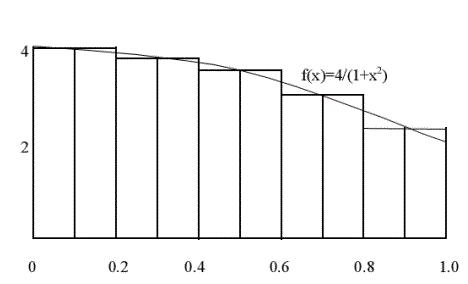

## Sequential Code

In [ ]:
%%file pi_seq.py
import numpy
import math

def compute_pi(n):
  h = 1.0 / n
  s = 0.0
  for i in range(n):
    x = h * (i + 0.5)
    s += 4.0 / (1.0 + x**2)
  return s * h

n = 10
pi = compute_pi(n)
error = abs(pi - math.pi)
print("pi is approximately %.16f, error is %.16f" % (pi, error))

Writing pi_seq.py


In [ ]:
%%time 
!python pi_seq.py

pi is approximately 3.1424259850010987, error is 0.0008333314113056
CPU times: user 6.52 ms, sys: 6.53 ms, total: 13.1 ms
Wall time: 319 ms


## Parallel Version

In [ ]:
%%file pi.py
from mpi4py import MPI
import numpy
import math

def compute_pi(n, start=0, step=1):
  h = 1.0 / n
  s = 0.0
  for i in range(start, n, step):
    print(i)
    x = h * (i + 0.5)
    s += 4.0 / (1.0 + x**2)
  return s * h

# comm = MPI.Comm.Get_parent()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
  n = 4
else:
  n = None

n = comm.bcast(n, root=0)

mypi = compute_pi(n, start=rank, step=size)
pi = comm.reduce(mypi, op=MPI.SUM, root=0)

if rank == 0:
    error = abs(pi - math.pi)
    print("pi is approximately %.16f, error is %.16f" % (pi, error))

Writing pi.py


In [ ]:
%%time 
!mpirun --allow-run-as-root -n 10 python pi.py

0
1
3
2
pi is approximately 3.1468005183939427, error is 0.0052078648041496
CPU times: user 31.4 ms, sys: 6.16 ms, total: 37.6 ms
Wall time: 2.32 s


# Example: Mandelbrot Set

## Sequential code

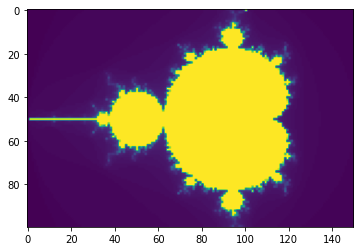

In [ ]:
import numpy as np
from matplotlib import pyplot

def mandelbrot(x, y, maxit):
  c = x + y*1j
  z = 0 + 0j
  it = 0
  while abs(z) < 2 and it < maxit:
    z = z**2 + c
    it += 1
  return it

x1, x2 = -2.0, 1.0
y1, y2 = -1.0, 1.0
w,  h  = 150, 100
maxit  = 127
C = np.zeros([h, w])
dx = (x2 - x1) / w
dy = (y2 - y1) / h
for i in range(h):
  y = y1 + i * dy
  for j in range(w):
    x = x1 + j * dx
    C[i, j] = mandelbrot(x, y, maxit)

from matplotlib import pyplot
pyplot.imshow(C, aspect='equal')
pyplot.show()

## Block distribution

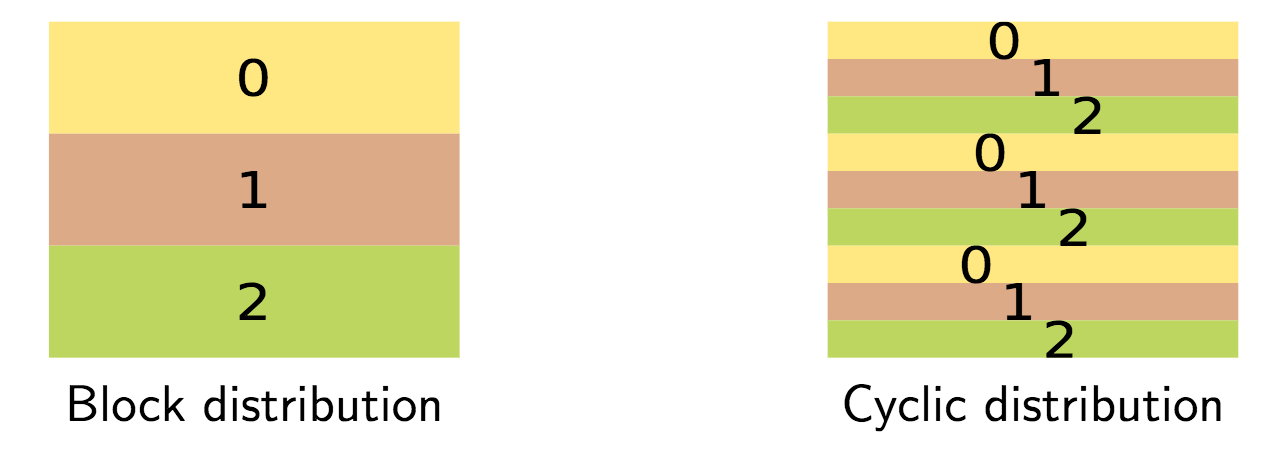

In [ ]:
%%file Mandelbrot_parallel.py
from mpi4py import MPI
import numpy as np
import math
from matplotlib import pyplot

def mandelbrot(x, y, maxit):
  c = x + y*1j
  z = 0 + 0j
  it = 0
  while abs(z) < 2 and it < maxit:
    z = z**2 + c
    it += 1
  return it

x1, x2 = -2.0, 1.0
y1, y2 = -1.0, 1.0
w,  h  = 150, 100
maxit  = 127

# comm = MPI.Comm.Get_parent()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# number of rows to compute here
N = h // size + (h % size > rank)
# first row to compute here
start = comm.scan(N)-N
# array to store local result
Cl = np.zeros([N, w], dtype='i')

# compute owned rows
dx = (x2 - x1) / w
dy = (y2 - y1) / h
for i in range(N):
  y = y1 + (i + start) * dy
  for j in range(w):
    x = x1 + j * dx
    Cl[i, j] = mandelbrot(x, y, maxit)

# gather results at root (process 0)
counts = comm.gather(N, root=0)
C = None
if rank == 0:
  C = np.zeros([h, w], dtype='i')

rowtype = MPI.INT.Create_contiguous(w)
rowtype.Commit()
comm.Gatherv(sendbuf=[Cl, MPI.INT],
             recvbuf=[C, (counts, None),
                      rowtype],
             root=0)
rowtype.Free()

if comm.rank == 0:
  from matplotlib import pyplot
  pyplot.imshow(C, aspect='equal')
  pyplot.savefig('Mandelbrot.png')

Writing Mandelbrot_parallel.py


In [ ]:
!mpirun --allow-run-as-root -n 3 python Mandelbrot_parallel.py

In [ ]:
!ls

all2all.py		mpiAllReduce.py   mpiScatter2.py	    pi.py
cartesian2d.py		mpiBroadcast1.py  mpiSendRecv1.py	    pi_seq.py
cartesian3d.py		mpiBroadcast2.py  mpi_sendrecv2.py	    sample_data
hello.py		mpiGather1.py	  mpiSendRecv2.py	    sum.py
Mandelbrot_parallel.py	mpiGather2.py	  mpiSendRecv_Exchange2.py  topology.py
Mandelbrot.png		mpiReduction.py   mpiSendRecv_Exchange.py
mpiAllGather.py		mpiScan.py	  mpi_sendrecv.py
mpiallReduce.py		mpiScatter1.py	  mpiSendRecv_Tagged.py


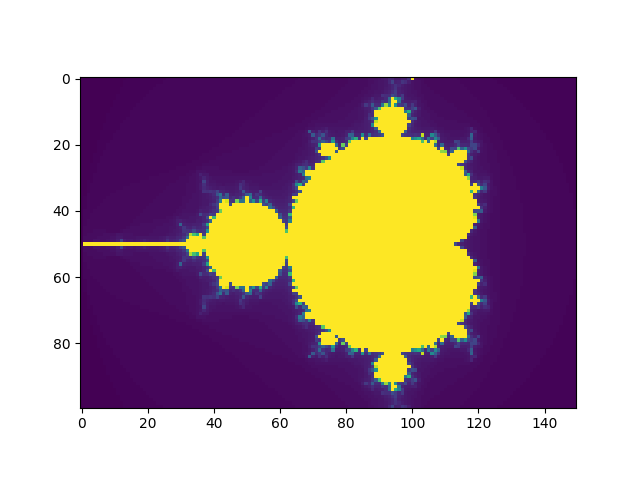

In [ ]:
from IPython.display import Image
Image('Mandelbrot.png')